# Neural network Training with MLPClassifier

In [2]:
import config.ConnectionConfig as cc
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

## 1. Setup Spark Environment

In [3]:
cc.setupEnvironment()
spark = cc.startLocalCluster("UFC_Neural_Network_Training")
spark.getActiveSession()

## 2. Loading the data

In [4]:
total_df = spark.read.csv("../data/processed_data/fight_total.csv", header=True, inferSchema=True)
total_df.show()

+----------------+--------------+-------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+-----------------+-----------+-----------------+--------------+-------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+-----------------+-----------+-------+
|        fighter1|fighter1_index|height1|weight_kg1|             avg_kd1|        avg_sub_att1|avg_td_percentage1|avg_significant_strike_percentage1|    avg_total_str1|        avg_round1| avg_ctrl_seconds1|total_wins1|total_losses1|total_draws1|  win_percentage1|reach_conv1|         fighter2|fighter2_index|height2|weight_kg2|             avg_kd2|        avg_sub_att2|avg_td_percentage2|avg_significant_strike_percentage2|    avg_total_str2|  

In [5]:
# select all columns except the fighter1 and fighter2 columns
data = total_df.drop('fighter1', 'fighter2')
# convert to a pandas dataframe
data = data.toPandas()
data

,fighter1_index,height1,weight_kg1,avg_kd1,avg_sub_att1,avg_td_percentage1,avg_significant_strike_percentage1,avg_total_str1,avg_round1,avg_ctrl_seconds1,...,avg_significant_strike_percentage2,avg_total_str2,avg_round2,avg_ctrl_seconds2,total_wins2,total_losses2,total_draws2,win_percentage2,reach_conv2,outcome
0,1608.0,195.58,92.98636,0.000000,0.000000,33.600000,40.000000,44.250000,1.750000,6.500000,...,48.642857,45.035714,1.714286,58.214286,2.0,5.0,0.0,28.571429,74.0,L/W
1,1015.0,172.72,70.30676,0.111111,0.333333,59.214286,34.222222,32.250000,1.722222,67.666667,...,21.000000,4.500000,1.000000,2.500000,0.0,2.0,0.0,0.000000,74.4,W/L
2,1015.0,172.72,70.30676,0.111111,0.333333,59.214286,34.222222,32.250000,1.722222,67.666667,...,33.969697,28.149254,1.835821,92.805970,16.0,12.0,0.0,57.142857,71.0,L/W
3,1015.0,172.72,70.30676,0.111111,0.333333,59.214286,34.222222,32.250000,1.722222,67.666667,...,40.652174,23.687500,1.708333,47.250000,6.0,4.0,0.0,60.000000,70.0,L/W
4,1015.0,172.72,70.30676,0.111111,0.333333,59.214286,34.222222,32.250000,1.722222,67.666667,...,51.437500,41.218750,1.875000,60.500000,9.0,4.0,0.0,69.230769,73.0,L/W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7543,1551.0,172.72,70.30676,0.000000,0.419355,46.448276,41.903226,32.725806,1.870968,156.451613,...,48.756757,32.927928,2.387387,73.918919,21.0,14.0,0.0,60.000000,70.0,L/W
7544,1551.0,172.72,70.30676,0.000000,0.419355,46.448276,41.903226,32.725806,1.870968,156.451613,...,36.545455,38.090909,1.545455,31.909091,2.0,4.0,0.0,33.333333,71.0,W/L
7545,2241.0,177.80,77.11064,0.400000,0.000000,75.000000,55.800000,27.300000,1.600000,74.000000,...,47.444444,37.055556,1.777778,45.888889,1.0,3.0,0.0,25.000000,70.0,W/L
7546,2241.0,177.80,77.11064,0.400000,0.000000,75.000000,55.800000,27.300000,1.600000,74.000000,...,36.578947,35.092105,1.894737,61.447368,9.0,5.0,0.0,64.285714,73.0,L/W


In [6]:
data.columns

Index(['fighter1_index', 'height1', 'weight_kg1', 'avg_kd1', 'avg_sub_att1',
       'avg_td_percentage1', 'avg_significant_strike_percentage1',
       'avg_total_str1', 'avg_round1', 'avg_ctrl_seconds1', 'total_wins1',
       'total_losses1', 'total_draws1', 'win_percentage1', 'reach_conv1',
       'fighter2_index', 'height2', 'weight_kg2', 'avg_kd2', 'avg_sub_att2',
       'avg_td_percentage2', 'avg_significant_strike_percentage2',
       'avg_total_str2', 'avg_round2', 'avg_ctrl_seconds2', 'total_wins2',
       'total_losses2', 'total_draws2', 'win_percentage2', 'reach_conv2',
       'outcome'],
      dtype='object')

In [7]:
print(data.shape)

(7548, 31)


## 3. Train Test Split

In [8]:
X = data.drop('outcome', axis=1)
y = data['outcome']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7548 entries, 0 to 7547
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   fighter1_index                      7548 non-null   float64
 1   height1                             7548 non-null   float64
 2   weight_kg1                          7548 non-null   float64
 3   avg_kd1                             7548 non-null   float64
 4   avg_sub_att1                        7548 non-null   float64
 5   avg_td_percentage1                  7548 non-null   float64
 6   avg_significant_strike_percentage1  7548 non-null   float64
 7   avg_total_str1                      7548 non-null   float64
 8   avg_round1                          7548 non-null   float64
 9   avg_ctrl_seconds1                   7548 non-null   float64
 10  total_wins1                         7548 non-null   float64
 11  total_losses1                       7548 no

In [9]:
# show all the column names
data.columns

Index(['fighter1_index', 'height1', 'weight_kg1', 'avg_kd1', 'avg_sub_att1',
       'avg_td_percentage1', 'avg_significant_strike_percentage1',
       'avg_total_str1', 'avg_round1', 'avg_ctrl_seconds1', 'total_wins1',
       'total_losses1', 'total_draws1', 'win_percentage1', 'reach_conv1',
       'fighter2_index', 'height2', 'weight_kg2', 'avg_kd2', 'avg_sub_att2',
       'avg_td_percentage2', 'avg_significant_strike_percentage2',
       'avg_total_str2', 'avg_round2', 'avg_ctrl_seconds2', 'total_wins2',
       'total_losses2', 'total_draws2', 'win_percentage2', 'reach_conv2',
       'outcome'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6793, 30), (755, 30), (6793,), (755,))

## 4. Feature Scaling

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6793, 30), (755, 30), (6793,), (755,))

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6793, 30), (755, 30), (6793,), (755,))

## 5. Hyperparameter tuning

In [14]:
pipeline = Pipeline([
    ('mlp', MLPClassifier())
])
param_grid = {
    'mlp__hidden_layer_sizes': [(5,5), (2,), (5,), (10, 10), (20, 20)],
    'mlp__activation': ['logistic', 'identity', 'tanh', 'relu'],
    'mlp__solver': ['lbfgs', 'sgd', 'adam'],
    'mlp__alpha': [0.001, 0.01, 0.1],
    'mlp__max_iter': [100, 10000, 20000, 30000, 50000],
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}
random_search = RandomizedSearchCV(pipeline, 
                                   param_distributions=param_grid, 
                                   n_iter=10, cv=5, 
                                   n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print(f'Best parameters: {random_search.best_params_}')


print(f'Best score: {random_search.best_score_}')
#Best parameters: {'mlp__solver': 'adam', 'mlp__max_iter': 20000, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (5, 5), 'mlp__activation': 'identity'}
#model = MLPClassifier(hidden_layer_sizes=(5, 5), solver='adam', max_iter=20000, activation='identity', learning_rate='adaptive', learning_rate_init=0.01, random_state=42)
model = random_search.best_estimator_

Best parameters: {'mlp__solver': 'sgd', 'mlp__max_iter': 100, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (10, 10), 'mlp__alpha': 0.1, 'mlp__activation': 'identity'}
Best score: 0.7883108410520167


C:\Users\xande\Desktop\Home\WielerManager2024\.venv\fight_predictor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## 6. Training the MLPRegressor

In [15]:
X_train.shape, y_train.shape

((6793, 30), (6793,))

In [16]:
#mlp = MLPClassifier(hidden_layer_sizes=(10,), solver='adam', max_iter=1000, activation='logistic', random_state=42)
model.fit(X_train, y_train)

C:\Users\xande\Desktop\Home\WielerManager2024\.venv\fight_predictor\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('mlp',
                 MLPClassifier(activation='identity', alpha=0.1,
                               hidden_layer_sizes=(10, 10),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, max_iter=100,
                               solver='sgd'))])

### 6.1 Accuracy score of the model

In [17]:
model.score(X_train, y_train)

0.7890475489474459

### 6.2 Possible outcomes of y

In [18]:
model.classes_

array(['D/D', 'L/W', 'NC/NC', 'W/L'], dtype='<U5')

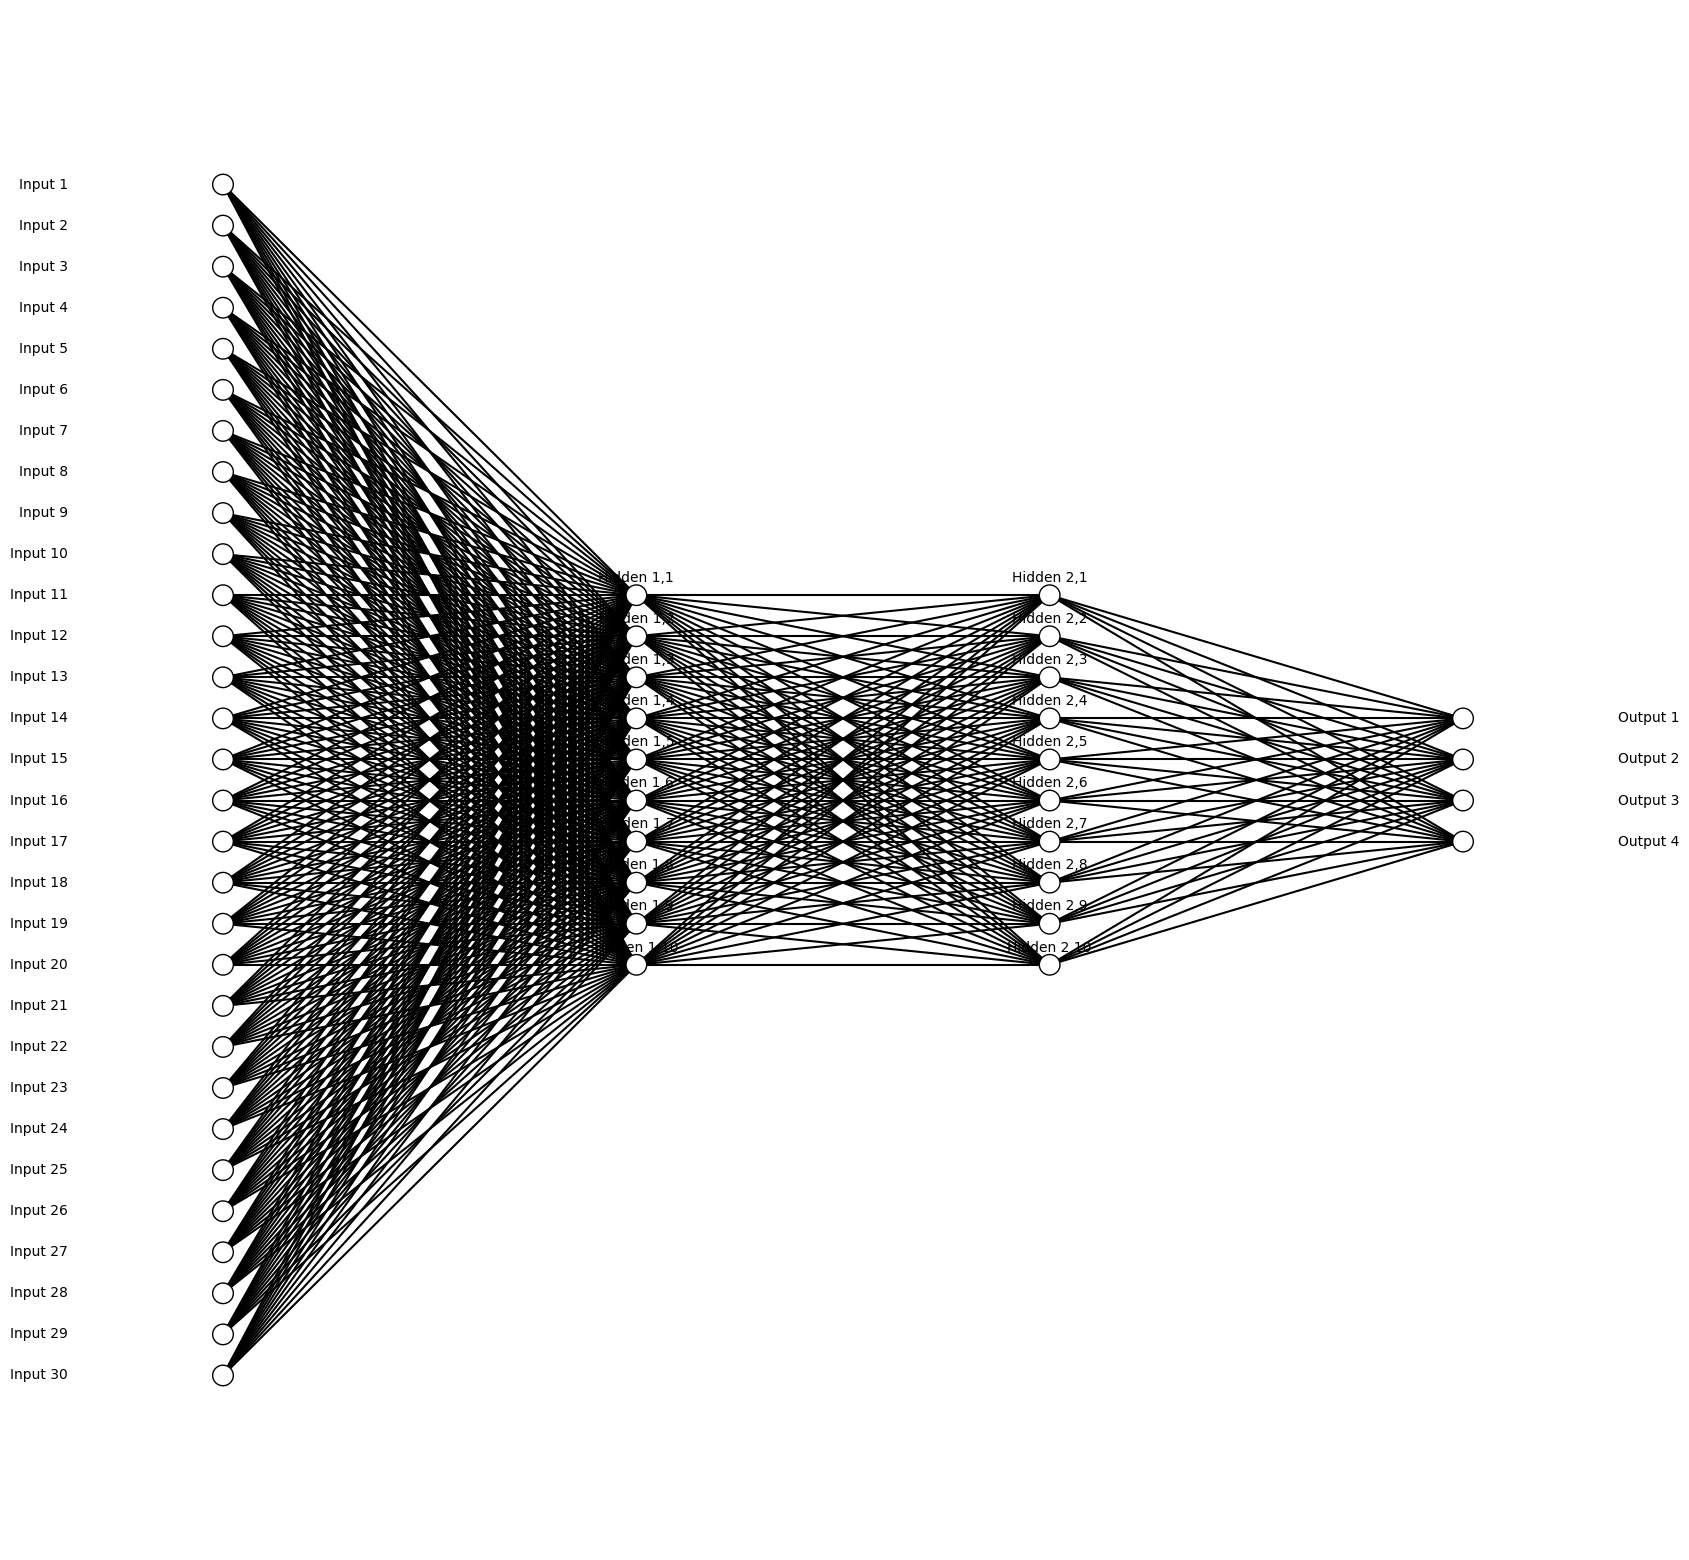

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    ax : matplotlib.axes.AxesSubplot : The axes on which to plot the cartoon (get e.g. by plt.gca())
    left : float : The center of the leftmost node(s) will be placed here
    right : float : The center of the rightmost node(s) will be placed here
    bottom : float : The center of the bottommost node(s) will be placed here
    top : float : The center of the topmost node(s) will be placed here
    layer_sizes : list of int : List containing the number of nodes in each layer
    '''
    
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
            if n == 0:
                ax.text(left - 0.1, layer_top - m * v_spacing, f'Input {m+1}', ha='right', va='center')
            elif n == len(layer_sizes) - 1:
                ax.text(n * h_spacing + left + 0.1, layer_top - m * v_spacing, f'Output {m+1}', ha='left', va='center')
            else:
                ax.text(n * h_spacing + left, layer_top - m * v_spacing + v_spacing / 4., f'Hidden {n},{m+1}', ha='center', va='bottom')

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c='k')
                ax.add_artist(line)

# Plot the neural network
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
ax.axis('off')
hidden_layers = random_search.best_params_['mlp__hidden_layer_sizes']
input_layer = X_train.shape[1]
output_layer = len(model.classes_)
layer_sizes = [input_layer] + list(hidden_layers) + [output_layer]
draw_neural_net(ax, .1, .9, .1, .9, layer_sizes)
plt.show()

In [20]:
# save the image 
# fig.savefig('neural_network.png')

## 7. Predictions

In [21]:
predictions_mlp = model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, predictions_mlp)
print('The accuracy of the MLPClassifier is: ', accuracy)

The accuracy of the MLPClassifier is:  0.8013245033112583


## 8. Predictions Probabilities
this table contains the probabilities of each possible outcome for each fight

In [23]:
predictions_proba = model.predict_proba(X_test)
normalized_proba = predictions_proba / predictions_proba.sum(axis=1)[:, np.newaxis]
normalized_proba_df = pd.DataFrame(normalized_proba, columns=model.classes_)

# add the actual outcome to the dataframe
normalized_proba_df['outcome_predicted'] = predictions_mlp
normalized_proba_df['outcome_actual'] = y_test.values

normalized_proba_df

,D/D,L/W,NC/NC,W/L,outcome_predicted,outcome_actual
0,0.002208,0.357654,0.051973,0.588166,W/L,W/L
1,0.001224,0.008349,0.009351,0.981075,W/L,W/L
2,0.003486,0.096028,0.006921,0.893564,W/L,L/W
3,0.008037,0.129826,0.006735,0.855402,W/L,W/L
4,0.001623,0.110131,0.005352,0.882894,W/L,L/W
...,...,...,...,...,...,...
750,0.002095,0.251358,0.003709,0.742839,W/L,W/L
751,0.011404,0.176666,0.006589,0.805342,W/L,L/W
752,0.020121,0.123757,0.014830,0.841291,W/L,W/L
753,0.001828,0.477641,0.008331,0.512199,W/L,W/L


## 9. Save the model

In [24]:
# joblib.dump(model, '../models/ufc_mlpclassifier_model.pkl')

## Make predictions on upcoming fights

In [26]:
fighter_details = spark.read.csv("../data/processed_data/fighter_details.csv", header=True, inferSchema=True)
fighter_details.show()

+-------------------+--------------------+--------------------+------------------+---------------------------------+------------------+------------------+------------------+----------+------------+-----------+------------------+------------------+----------+---------+-------------+
|            FIGHTER|              AVG_KD|         AVG_SUB_ATT| AVG_TD_Percentage|AVG_Significant_Strike_Percentage|     AVG_TOTAL_STR|         AVG_ROUND|  AVG_CTRL_SECONDS|total_wins|total_losses|total_draws|    Win_Percentage|         Height_CM|Reach_Conv|Weight_KG|fighter_index|
+-------------------+--------------------+--------------------+------------------+---------------------------------+------------------+------------------+------------------+----------+------------+-----------+------------------+------------------+----------+---------+-------------+
|     Matt Van Buren|                 0.0|                 0.0|              33.6|                             40.0|             44.25|              1.

In [27]:
from pyspark.sql.functions import to_date, col

fighter_details = fighter_details.createOrReplaceTempView("fighter_details")

In [29]:

from pyspark.sql.functions import date_format

upcoming_fights_event = spark.read.csv("../data/processed_data/upcoming_events_fights.csv", header=True, inferSchema=True)
# set the event_data as type date
upcoming_fights_event = upcoming_fights_event.withColumn("event_date", to_date(col("event_date"), "MMMM dd, yyyy"))
upcoming_fights_event = upcoming_fights_event.withColumn("event_date", date_format(col("event_date"), "yyyy-MM-dd"))
upcoming_fights_event.show()

+--------------------+----------+--------------------+--------------------+----------------+
|               event|event_date|      event_location|            fighter1|        fighter2|
+--------------------+----------+--------------------+--------------------+----------------+
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|     Matheus Nicolau|      Alex Perez|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|          Ryan Spann|   Bogdan Guskov|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|       Ariane Lipski|    Karine Silva|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|         Austen Lane|   Jhonata Diniz|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|     Jonathan Pearce|     David Onama|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|           Tim Means|      Uros Medic|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|          Rani Yahya|    Victor Henry|
|UFC Fight Night: ...|2024-04-27|Las Vegas, Nevada...|      Austin Hub

In [30]:
upcoming_fights_event.createOrReplaceTempView("upcoming_fights_info")

In [31]:
# Index(['fighter1_index', 'height1', 'weight_kg1', 'avg_kd1', 'avg_sub_att1',
#       'avg_td_percentage1', 'avg_significant_strike_percentage1',
#       'avg_total_str1', 'avg_round1', 'avg_ctrl_seconds1', 'total_wins1',
#       'total_losses1', 'total_draws1', 'win_percentage1', 'reach_conv1',
#       'fighter2_index', 'height2', 'weight_kg2', 'avg_kd2', 'avg_sub_att2',
#       'avg_td_percentage2', 'avg_significant_strike_percentage2',
#       'avg_total_str2', 'avg_round2', 'avg_ctrl_seconds2', 'total_wins2',
#       'total_losses2', 'total_draws2', 'win_percentage2', 'reach_conv2',
#       'outcome'],
#      dtype='object')
upcoming_fights = spark.sql("""
                            SELECT 
                            fd1.fighter_index AS fighter1_index, 
                            fd1.Height_CM AS height1, 
                            fd1.Weight_KG AS weight_kg1, 
                            fd1.AVG_KD AS avg_kd1, 
                            fd1.avg_sub_att AS avg_sub_att1, 
                            fd1.avg_td_percentage AS avg_td_percentage1, 
                            fd1.avg_significant_strike_percentage AS avg_significant_strike_percentage1, 
                            fd1.avg_total_str AS avg_total_str1, 
                            fd1.avg_round AS avg_round1, 
                            fd1.avg_ctrl_seconds AS avg_ctrl_seconds1, 
                            fd1.total_wins AS total_wins1, 
                            fd1.total_losses AS total_losses1, 
                            fd1.total_draws AS total_draws1, 
                            fd1.win_percentage AS win_percentage1, 
                            fd1.reach_conv AS reach_conv1, 
                            fd2.fighter_index AS fighter2_index,
                            fd2.Height_CM AS height2,
                            fd2.Weight_KG AS weight_kg2,
                            fd2.AVG_KD AS avg_kd2,
                            fd2.avg_sub_att AS avg_sub_att2,
                            fd2.avg_td_percentage AS avg_td_percentage2,
                            fd2.avg_significant_strike_percentage AS avg_significant_strike_percentage2,
                            fd2.avg_total_str AS avg_total_str2,
                            fd2.avg_round AS avg_round2,
                            fd2.avg_ctrl_seconds AS avg_ctrl_seconds2,
                            fd2.total_wins AS total_wins2,
                            fd2.total_losses AS total_losses2,
                            fd2.total_draws AS total_draws2,
                            fd2.win_percentage AS win_percentage2,
                            fd2.reach_conv AS reach_conv2
                            FROM upcoming_fights_info AS uf 
                            JOIN fighter_details AS fd1 ON uf.fighter1 = fd1.FIGHTER 
                            JOIN fighter_details AS fd2 ON uf.fighter2 = fd2.FIGHTER 
                            """)
upcoming_fights.show()

+--------------+------------------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+------------------+-----------+--------------+------------------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+-----------------+-----------+
|fighter1_index|           height1|weight_kg1|             avg_kd1|        avg_sub_att1|avg_td_percentage1|avg_significant_strike_percentage1|    avg_total_str1|        avg_round1| avg_ctrl_seconds1|total_wins1|total_losses1|total_draws1|   win_percentage1|reach_conv1|fighter2_index|           height2|weight_kg2|             avg_kd2|        avg_sub_att2|avg_td_percentage2|avg_significant_strike_percentage2|    avg_total_str2|        avg_round2| avg_ctrl_secon

In [32]:
upcoming_fights.createOrReplaceTempView("upcoming_fights")
upcoming_fights_pd = upcoming_fights.toPandas()
upcoming_fights_scaled = scaler.transform(upcoming_fights_pd)
y_pred = model.predict(upcoming_fights_scaled)
y_pred_proba = model.predict_proba(upcoming_fights_scaled)
y_pred_proba_normalized = y_pred_proba / y_pred_proba.sum(axis=1)[:, np.newaxis]
y_pred_proba_normalized_df = pd.DataFrame(y_pred_proba_normalized, columns=model.classes_)
y_pred_proba_normalized_df['outcome_predicted'] = y_pred
# to join upcoming_fights_pd and y_pred_proba_normalized_df, we need to reset the index of upcoming_fights_pd\
upcoming_fights_pd.reset_index(drop=True, inplace=True)
upcoming_fights_predictions = pd.concat([upcoming_fights_pd, y_pred_proba_normalized_df], axis=1)
pred_spark = spark.createDataFrame(upcoming_fights_predictions)
pred_spark.createOrReplaceTempView("predictions")
pred_spark.show()

+--------------+------------------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+------------------+-----------+--------------+------------------+----------+--------------------+--------------------+------------------+----------------------------------+------------------+------------------+------------------+-----------+-------------+------------+-----------------+-----------+--------------------+-------------------+--------------------+--------------------+-----------------+
|fighter1_index|           height1|weight_kg1|             avg_kd1|        avg_sub_att1|avg_td_percentage1|avg_significant_strike_percentage1|    avg_total_str1|        avg_round1| avg_ctrl_seconds1|total_wins1|total_losses1|total_draws1|   win_percentage1|reach_conv1|fighter2_index|           height2|weight_kg2|             avg_kd2|        avg_sub_att2|avg_td

In [33]:
results = spark.sql("""
                    SELECT ufi.event, fd1.FIGHTER as fighter1, fd2.FIGHTER as fighter2, outcome_predicted, `W/L`  
                    FROM upcoming_fights AS uf
                    JOIN predictions as p ON uf.fighter1_index = p.fighter1_index AND uf.fighter2_index = p.fighter2_index 
                    JOIN fighter_details AS fd1 ON uf.fighter1_index = fd1.fighter_index
                    JOIN fighter_details AS fd2 ON uf.fighter2_index = fd2.fighter_index
                    JOIN upcoming_fights_info as ufi ON fd1.FIGHTER = ufi.fighter1 AND fd2.FIGHTER = ufi.fighter2
                    GROUP BY ufi.event, fd1.FIGHTER, fd2.FIGHTER, `W/L`, outcome_predicted
                    """)
results.show(100)

+--------------------+--------------------+--------------------+-----------------+--------------------+
|               event|            fighter1|            fighter2|outcome_predicted|                 W/L|
+--------------------+--------------------+--------------------+-----------------+--------------------+
|UFC Fight Night: ...|       Tabatha Ricci|        Tecia Torres|              W/L|  0.6229463675182279|
|UFC Fight Night: ...|       Edson Barboza|       Lerone Murphy|              L/W| 0.11335984399837412|
|UFC Fight Night: ...|     Jonathan Pearce|         David Onama|              W/L|  0.6152830423858613|
|UFC Fight Night: ...|         Tim Elliott|       Tatsuro Taira|              L/W| 0.06414075129994107|
|UFC 301: Pantoja ...|      Michel Pereira|     Makhmud Muradov|              W/L|  0.7389484695932098|
|UFC Fight Night: ...|     Kelvin Gastelum|    Daniel Rodriguez|              L/W|  0.3876320669835906|
|UFC 302: Makhache...|          Niko Price|      Jeremiah Wells|

In [ ]:
# results.toPandas().to_csv('../processed_data/upcoming_fights_predictions.csv', index=False)

#### Check predictions of individual fight to see if the model predicted the same outcome and probabilities

In [34]:
upcoming_fights = spark.sql("""
                            SELECT 
                            fd1.fighter_index AS fighter1_index, 
                            fd1.Height_CM AS height1, 
                            fd1.Weight_KG AS weight_kg1, 
                            fd1.AVG_KD AS avg_kd1, 
                            fd1.avg_sub_att AS avg_sub_att1, 
                            fd1.avg_td_percentage AS avg_td_percentage1, 
                            fd1.avg_significant_strike_percentage AS avg_significant_strike_percentage1, 
                            fd1.avg_total_str AS avg_total_str1, 
                            fd1.avg_round AS avg_round1, 
                            fd1.avg_ctrl_seconds AS avg_ctrl_seconds1, 
                            fd1.total_wins AS total_wins1, 
                            fd1.total_losses AS total_losses1, 
                            fd1.total_draws AS total_draws1, 
                            fd1.win_percentage AS win_percentage1, 
                            fd1.reach_conv AS reach_conv1, 
                            fd2.fighter_index AS fighter2_index,
                            fd2.Height_CM AS height2,
                            fd2.Weight_KG AS weight_kg2,
                            fd2.AVG_KD AS avg_kd2,
                            fd2.avg_sub_att AS avg_sub_att2,
                            fd2.avg_td_percentage AS avg_td_percentage2,
                            fd2.avg_significant_strike_percentage AS avg_significant_strike_percentage2,
                            fd2.avg_total_str AS avg_total_str2,
                            fd2.avg_round AS avg_round2,
                            fd2.avg_ctrl_seconds AS avg_ctrl_seconds2,
                            fd2.total_wins AS total_wins2,
                            fd2.total_losses AS total_losses2,
                            fd2.total_draws AS total_draws2,
                            fd2.win_percentage AS win_percentage2,
                            fd2.reach_conv AS reach_conv2
                            FROM upcoming_fights_info AS uf 
                            JOIN fighter_details AS fd1 ON uf.fighter1 = fd1.FIGHTER 
                            JOIN fighter_details AS fd2 ON uf.fighter2 = fd2.FIGHTER 
                            WHERE fd1.FIGHTER = 'Islam Makhachev'
                            """)
upcoming_fights.show()

+--------------+-------+----------+-------------------+-------------------+------------------+----------------------------------+-----------------+----------+------------------+-----------+-------------+------------+-----------------+-----------+--------------+-------+----------+-------------------+------------------+------------------+----------------------------------+-----------------+-----------------+------------------+-----------+-------------+------------+-----------------+-----------+
|fighter1_index|height1|weight_kg1|            avg_kd1|       avg_sub_att1|avg_td_percentage1|avg_significant_strike_percentage1|   avg_total_str1|avg_round1| avg_ctrl_seconds1|total_wins1|total_losses1|total_draws1|  win_percentage1|reach_conv1|fighter2_index|height2|weight_kg2|            avg_kd2|      avg_sub_att2|avg_td_percentage2|avg_significant_strike_percentage2|   avg_total_str2|       avg_round2| avg_ctrl_seconds2|total_wins2|total_losses2|total_draws2|  win_percentage2|reach_conv2|
+---

In [35]:
upcoming_fights_pd = upcoming_fights.toPandas()
upcoming_fights_scaled = scaler.transform(upcoming_fights_pd)
y_pred = model.predict(upcoming_fights_scaled)
y_pred_proba = model.predict_proba(upcoming_fights_scaled)
y_pred_proba_normalized = y_pred_proba / y_pred_proba.sum(axis=1)[:, np.newaxis]
y_pred_proba_normalized_df = pd.DataFrame(y_pred_proba_normalized, columns=model.classes_)
y_pred_proba_normalized_df['outcome_predicted'] = y_pred
# to join upcoming_fights_pd and y_pred_proba_normalized_df, we need to reset the index of upcoming_fights_pd\
upcoming_fights_pd.reset_index(drop=True, inplace=True)
upcoming_fights_predictions = pd.concat([upcoming_fights_pd, y_pred_proba_normalized_df], axis=1)
pred_spark = spark.createDataFrame(upcoming_fights_predictions)
pred_spark.createOrReplaceTempView("predictions")
pred_spark.show()

+--------------+-------+----------+-------------------+-------------------+------------------+----------------------------------+-----------------+----------+------------------+-----------+-------------+------------+-----------------+-----------+--------------+-------+----------+-------------------+------------------+------------------+----------------------------------+-----------------+-----------------+------------------+-----------+-------------+------------+-----------------+-----------+--------------------+-------------------+-------------------+------------------+-----------------+
|fighter1_index|height1|weight_kg1|            avg_kd1|       avg_sub_att1|avg_td_percentage1|avg_significant_strike_percentage1|   avg_total_str1|avg_round1| avg_ctrl_seconds1|total_wins1|total_losses1|total_draws1|  win_percentage1|reach_conv1|fighter2_index|height2|weight_kg2|            avg_kd2|      avg_sub_att2|avg_td_percentage2|avg_significant_strike_percentage2|   avg_total_str2|       avg_ro

In [38]:
results = spark.sql("""
                    SELECT fd1.FIGHTER as fighter1, fd2.FIGHTER as fighter2, `W/L` as accuracy, outcome_predicted 
                    FROM upcoming_fights AS uf
                    JOIN predictions as p ON uf.fighter1_index = p.fighter1_index AND uf.fighter2_index = p.fighter2_index 
                    JOIN fighter_details AS fd1 ON uf.fighter1_index = fd1.fighter_index
                    JOIN fighter_details AS fd2 ON uf.fighter2_index = fd2.fighter_index
                    GROUP BY fd1.FIGHTER, fd2.FIGHTER, `W/L`, outcome_predicted
                    """)
results.show(100)

+---------------+--------------+------------------+-----------------+
|       fighter1|      fighter2|          accuracy|outcome_predicted|
+---------------+--------------+------------------+-----------------+
|Islam Makhachev|Dustin Poirier|0.8890620517693599|              W/L|
+---------------+--------------+------------------+-----------------+

